# Neural Style Transfer Part 1, Reproducing Content

This example implements the content transfer part of neural style transfer. If we suppose that a CNN is just a transfer function, so that $x^\prime = f(x)$, then the question we're posing here is the following: given a pre-trained CNN, VGG16 in our case, and an input image $x$, how can we obtain $y$, which is randomly initialized, that produces $y^\prime = f(y)$, so that $x^\prime$ and $y^\prime$ are similar? In other words, we try to minimize the content loss: 

$$loss = \frac{1}{n} \sum_{n=1}^{N} (f(y_n) - f(x_n))^2$$

In a sense we are trying to reproduce the original image $x$ using the feature map produced by the CNN. Depending on which layer of features we use to reproduce the original image, the resulting image $y$ resembles more (using early layers) or less (using later layers) the original image. Another interesting point to note is that in the optimization phase we're not optimizing the weights of the neural network itself, these are given, but the input image $y$.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Reduce TF verbosity
import tensorflow as tf
tf.get_logger().setLevel('INFO') # Reduce TF verbosity
tf.compat.v1.disable_eager_execution()

from __future__ import print_function, division
from builtins import range, input

from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
import keras.backend as K

import numpy as np
import math
import matplotlib.pyplot as plt

from scipy.optimize import fmin_l_bfgs_b

In [2]:
def VGG16_with_AvgPool(shape):
    '''Loads a pre-trained VGG16 and replaces max pooling by average pooling.
    
    Max pooling is too aggressive at throwing away information, whereas average-pooling
    retains more of the original information.
    '''
    
    vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)

    i = vgg.input
    x = i
    
    for layer in vgg.layers:
        if layer.__class__ == MaxPooling2D:
            # replace it with average pooling
            x = AveragePooling2D()(x)
        else:
            x = layer(x)

    return Model(i, x)


def VGG16_AvgPool_CutOff(shape, num_convs):
    '''Loads a pre-trained VGG16 with average-pooling, and limits the number of
    convolutional layers.
    '''
    
    if num_convs < 1 or num_convs > 13:
        print('Number of convolutions must be in the range [1, 13]')
        return None
    
    vgg = VGG16_with_AvgPool(shape)
    
    n = 0
    output = None
    
    for layer in vgg.layers:
        if layer.__class__ == Conv2D:
            n += 1
        if n >= num_convs:
            output = layer.output
            break
            
    return Model(vgg.input, output)
            

def unpreprocess(img):
    '''Removes VGG16 preprocessing from the given image.
    '''
    
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 126.68
    img = img[..., ::-1]
    
    return img

def scale_img(x):
    '''Scales the image between [0...1].
    '''
    
    x = x - x.min()
    x = x / x.max()
    
    return x

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_1:0", shape=(None, 252, 200, 3), dtype=float32)
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_1:0", shape=(None, 252, 200, 3), dtype=float32)


/home/jarno/miniconda3/envs/tensorflow2-gpu/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Iteration: 0, loss: 13609.5146484375
Iteration: 1, loss: 6281.6875
Iteration: 2, loss: 3941.174560546875
Iteration: 3, loss: 2790.9775390625
Iteration: 4, loss: 2138.347412109375
Iteration: 5, loss: 1718.1220703125
Iteration: 6, loss: 1440.6927490234375
Iteration: 7, loss: 1243.7857666015625
Iteration: 8, loss: 1094.9609375
Iteration: 9, loss: 985.058837890625


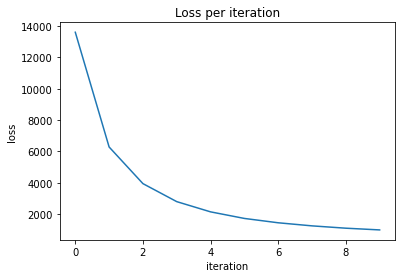

In [3]:
img_path = './large_files/van_gogh.jpeg'

img = image.load_img(img_path)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

batch_shape = x.shape
shape = x.shape[1:]

# Create a VGG model with 5 CNN layers
content_model = VGG16_AvgPool_CutOff(shape, 5)

# Target output, i.e. this defines the output features for the given input x
target = K.variable(content_model.predict(x))

# Loss function
loss = K.mean(K.square(target - content_model.output))

# Gradient of the loss function
gradients = K.gradients(loss, content_model.input)

# A function that returns both, loss and gradients
get_loss_and_gradients = K.function(
    inputs = [content_model.input],
    outputs = [loss] + gradients
)

# A wrapper that returns both, loss and gradients, in float64 format
def get_loss_and_gradients_wrapper(x_vec, *batch_shape_):
    '''Calls the get_loss_and_gradients-function, and returns a tuplet of loss and gradient
    
    Scipy fmin_l_bfgs_b expects the the loss- and gradient to be in float64 format.
    '''
    loss, gradients = get_loss_and_gradients([x_vec.reshape(*batch_shape_)])
    return loss.astype(np.float64), gradients.flatten().astype(np.float64)

# Losses per iteration
losses = []
images = []

# Initialize the input image to random values
x = np.random.randn(np.prod(batch_shape))

# 10 rounds of iterations
for i in range(10):
    # Reshape, scale and store the solution to a list
    temp = np.copy(x).reshape(*batch_shape[1::])
    temp = scale_img(unpreprocess(temp))
    images.append(temp)
    
    # Calculate a new solution
    x, l, _ = fmin_l_bfgs_b(
        func = get_loss_and_gradients_wrapper,
        args = batch_shape,
        x0 = x,
        maxfun = 20)
    x = np.clip(x, -127, 127)
    print(f'Iteration: {i}, loss: {l}')
    losses.append(l)

plt.plot(losses)
plt.title('Loss per iteration')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

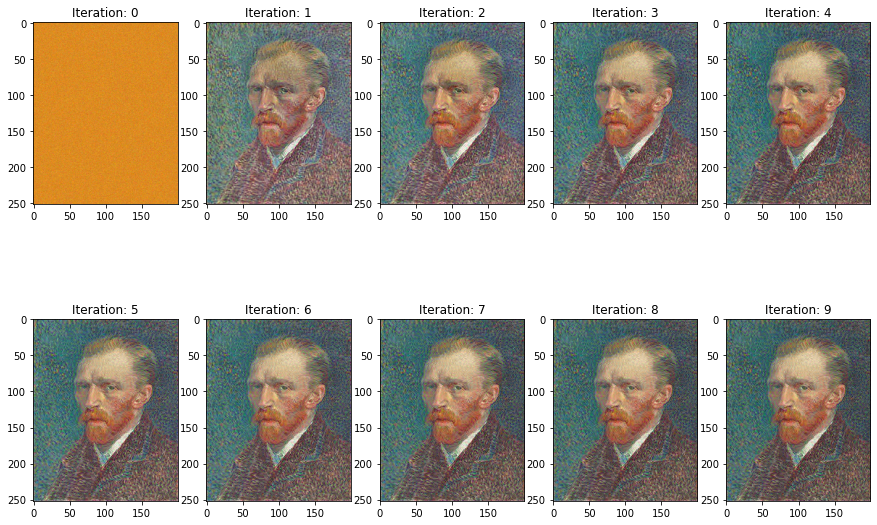

In [4]:
# Show the solution after each iteration
cols = 5
rows = math.ceil(len(images)/cols)
fig, axis = plt.subplots(rows, cols, figsize=(15, 10))

for index in range(len(images)):
    i = math.floor(index/cols)
    j = index % cols
    axis[i, j].imshow(images[index])
    axis[i, j].set_title(f'Iteration: {index}')